## 1.- Import standard libraries

In [1]:
# Import custom libraries from local folder.
from importlib import reload
import os
import sys
sys.path.append("..")

# Import nn module from torch to replicate kessler tool
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import utils library containing miscellaneous functions/classes
from scapy import utils

# Import library to import Kelvins challlenge data
from scapy.data import kelvins_challenge_events

# Import SCALIB modules for NN development
import scapy.cef as cef            # NN models

# Set overall seed for reproducibility
utils.seed(1)

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in utils.cwd:
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)

print(utils.cwd)

/Users/jjrr/Documents/SCA-Project/scalib


## 2.- Data preparation

In [2]:
#As an example, we first show the case in which the data comes from the Kelvins competition.
#For this, we built a specific converter that takes care of the conversion from Kelvins format
#to standard CDM format (the data can be downloaded at https://kelvins.esa.int/collision-avoidance-challenge/data/):
filepath = os.path.join(utils.cwd,'data','esa-challenge','train_data.csv')

# Get ConjunctionEventsDataset object 
events = kelvins_challenge_events(filepath,
            drop_features = ['c_rcs_estimate', 't_rcs_estimate'], 
            num_events = 2000)

# Get features to train the model.
nn_features = events.common_features(only_numeric=True)
nn_features = [f for f in nn_features if f!='COLLISION_PROBABILITY']
# Define input and output size of the RNN model.
input_size = len(nn_features)
output_size = len(nn_features)

# Split data into a test set (5% of the total number of events)
len_test_set=int(0.05*len(events))

# Get Events to test model: used to compute the error the model would have in 
# run-mode.
events_test=events[-len_test_set:]
print('\nTest data:', events_test)

# Get events used for training and validation:
# - Training set: Used to train the model and backpropagate the loss.
# - Validation set: Used to compute the loss so that hyperparameters can be 
#   adjusted.
events_train_and_val=events[:-len_test_set]
print('Training and validation data:', events_train_and_val)

Kelvins Challenge dataset imported from external file (162634 entries):
/Users/jjrr/Documents/SCA-Project/scalib/data/esa-challenge/train_data.csv

KELVINS DATASET IMPORT:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:10s |  189.93   | Dataset imported (2000 events).         

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:31s |   62.82   | Pandas DataFrame saved.                                 

Test data: ConjunctionEventsDataset(Events:100 | Number of CDMs per event: 1 (min), 22 (max), 12.80 (mean))
Training and validation data: ConjunctionEventsDataset(Events:1900 | Number of CDMs per event: 1 (min), 22 (max), 13.45 (mean))


## 3.- Recurrent Neural Network models assessment for Conjunction Event forecasting

### 3.1.- Networks considered in the research

In [4]:
# Import all networks variations
import scapy.devs.nws as nws
reload(nws)

# Iterate over all the networks to get their parameters
data_networks = {}
for name, network in nws.networks.items():

    # Get number of parameters in the model.
    num_params = sum(p.numel() for p in network.parameters())
    for layer_name, layer in network.items():
        if any(arch in layer_name for arch in ['lstm', 'gru', 'mgu']):
            hs = layer.hidden_size
            nl = layer.num_layers
            break
    data_networks[name]=[num_params, hs, nl]

# Convert dictionary to pandas DataFrame
df_networks = pd.DataFrame.from_dict(data=data_networks, 
                                     columns =['parameters', 
                                               'hidden_size', 
                                               'num_layers'], 
                                     orient='index')

# Display table with networks subject to study
display(df_networks)

latex_table = utils.df2latex(df_networks,include_header=True) \
    .replace('\\\\','\\\\\n') \
    .replace('_',' ') \
    .replace('000 &', ' &') \
    .replace('000 \\\\', ' \\\\') \
    .replace(' mean norm', '') \
    .replace('cc} &', 'cc}\n &') \
    .replace('\hline ', '').upper().split('\n')

for r, row in enumerate(latex_table):
    if r==0 or (r+1)==len(latex_table): latex_table[r] = row.lower()
    if r==1 and (r+1)<len(latex_table): latex_table[r] = f'Configuration {row} \hline'
    if r>1 and (r+1)<len(latex_table): 
        latex_table[r] = f' {row}'
        row = latex_table[r].split(' & ')
        for c, col in enumerate(row):
            if c>=2:
                row[c] = '' + row[c] + ''
            latex_table[r] = ' & '.join(row).replace(' \\\\}', '} \\\\')
print('\n'.join(latex_table).replace('TEXTBF','textbf'))

/Users/jjrr/Documents/SCA-Project/scalib/notebooks/../scalib/layers.py:192: UserWarning: 
Dropout parameter in LSTM class adds dropout layers after all but last recurrent layer. 
It expects num_layers greater > 1, but got num_layers = 1.
  warnings.warn(
/Users/jjrr/Documents/SCA-Project/scalib/notebooks/../scalib/layers.py:405: UserWarning: 
Dropout parameter in LSTM class adds dropout layers after all but last recurrent layer. 
It expects num_layers greater > 1, but got num_layers = 1.
  warnings.warn(


,parameters,hidden_size,num_layers
lstm_vanilla,927762,264,2
lstm_nig,927246,306,2
lstm_nog,927246,306,2
lstm_nfg,927246,306,2
lstm_nigaf,927762,264,2
lstm_nogaf,927762,264,2
lstm_nfgaf,927762,264,2
lstm_pc,924052,217,2
lstm_fb1,928818,264,2
lstm_slim1,925607,313,2


\begin{tabular}{cccc}
Configuration  & \textbf{PARAMETERS} & \textbf{HIDDEN SIZE} & \textbf{NUM LAYERS} \\ \hline
 LSTM VANILLA & 927762 & 264 & 2 \\
 LSTM NIG & 927246 & 306 & 2 \\
 LSTM NOG & 927246 & 306 & 2 \\
 LSTM NFG & 927246 & 306 & 2 \\
 LSTM NIGAF & 927762 & 264 & 2 \\
 LSTM NOGAF & 927762 & 264 & 2 \\
 LSTM NFGAF & 927762 & 264 & 2 \\
 LSTM PC & 924052 & 217 & 2 \\
 LSTM FB1 & 928818 & 264 & 2 \\
 LSTM SLIM1 & 925607 & 313 & 2 \\
 LSTM SLIM2 & 923729 & 313 & 2 \\
 LSTM SLIM3 & 926667 & 897 & 1 \\
 LSTM ATTN-VANILLA & 926966 & 230 & 1 \\
 GRU VANILLA & 925410 & 306 & 2 \\
 GRU SLIM1 & 926130 & 354 & 2 \\
 GRU SLIM2 & 924714 & 354 & 2 \\
 GRU SLIM3 & 927700 & 898 & 1 \\
 GRU MUT3 & 927246 & 306 & 2 \\
 GRU ATTN-VANILLA & 922178 & 256 & 1 \\
 MGU VANILLA & 924274 & 376 & 2 \\
 MGU SLIM1 & 926223 & 417 & 2 \\
 MGU SLIM2 & 925389 & 417 & 2 \\
 MGU SLIM3 & 924873 & 897 & 1 \\
 MGU ATTN-VANILLA & 924990 & 294 & 1 \\
\end{tabular}


### 3.2.- Retrieving results from trained models

In [81]:
# Get path of the folder where all trained model parameters are saved
folderpath = os.path.join(utils.cwd, 'models', 'parameters', 'cef')

# Initialize dictionary to keep models performance.
data = dict()
data_plot = dict()

# Iterate over all elements in the folder
for f in os.listdir(folderpath):

    # Check if it is a model file.
    if not (f.startswith('cef') and f.endswith(".pt")): continue
    
    # Get models parameters
    parameters = torch.load(os.path.join(folderpath, f))

    # Get training results
    results = parameters['learn_results']

    # Get the name of the network from the file name f
    network_name = '_'.join(f.split('_')[1:3])
    
    data_plot[network_name] = {'epochs':results['epoch'],
                           'validation_loss': results['validation_loss'],
                           'total_iterations':results['total_iterations']}
    
    data[network_name] = [parameters['num_params'],
                      results['validation_loss'][-1],
                      results['total_iterations'][-1],
                      results['epoch'][-1]]

# Convert data dictionary as pandas DataFrame and sort it by loss.
columns = ['parameters', 'validation_mse_loss', 'iterations', 'epochs']
df_training = pd.DataFrame.from_dict(columns = columns, 
                                     data=data, orient='index')

# Join training and networks DataFrame to have all the details.
df_training = df_networks.join(df_training.drop(['parameters'], axis=1))

df_training.sort_values(by='validation_mse_loss', ascending=True, inplace=True)

# Save results into a CSV file.
display(df_training)



,parameters,hidden_size,num_layers,validation_mse_loss,iterations,epochs
gru_attn-vanilla,922178,256,1,0.076238,3120,30
mgu_attn-vanilla,924990,294,1,0.087260,4160,40
lstm_attn-vanilla,926966,230,1,0.099847,3120,30
gru_slim3,927700,898,1,0.103906,3120,30
lstm_slim3,926667,897,1,0.108071,3120,30
mgu_slim3,924873,897,1,0.110953,3120,30
lstm_nog,927246,306,2,0.127202,3120,30
mgu_slim1,926223,417,2,0.128891,3120,30
gru_mut3,927246,306,2,0.129323,3120,30
gru_vanilla,925410,306,2,0.129496,3120,30


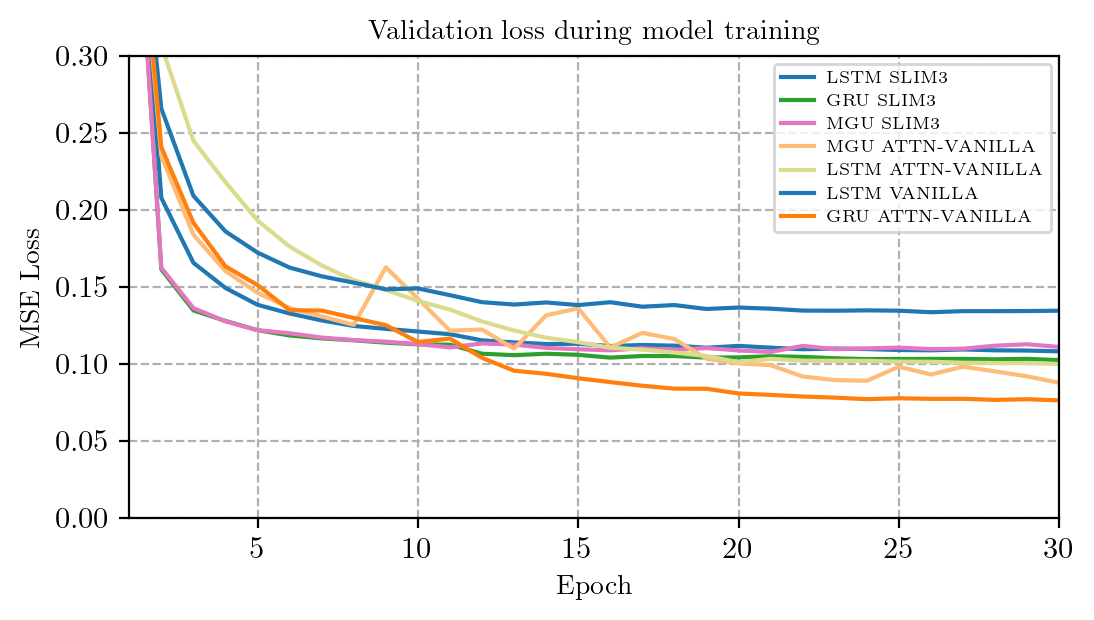

In [5]:
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(0,21,2)] + \
         [cmap(i+1) for i in range(0,21,2)]

# Get images folder and filepath
imagesfolder = os.path.join(utils.cwd, 'images')
filepath = os.path.join(imagesfolder,'training_validation_loss.pdf')

# Iterate over all elements in the folder
fig, ax = plt.subplots(figsize=(6,3))

# Iterate over all trained network
for i, (network_name, data) in enumerate(data_plot.items()):

    if not (network_name.endswith('attn-vanilla') or \
            network_name.endswith('slim3') or \
            network_name=='lstm_vanilla'): continue

    data = pd.Series(data['validation_loss'], data['epochs'])
            
    ax.plot(data.drop_duplicates(keep='first'), 
            label = network_name.replace('_',' ').upper(), color = colors[i%20])

ax.set_title('Validation loss during model training', fontsize=10)
ax.set_xlabel('Epoch', fontsize=10)
ax.set_ylabel('MSE Loss', fontsize=10)
ax.set_ylim(0,0.3)
ax.set_xlim(1, 30)
ax.legend(fontsize=6, loc='best')#, bbox_to_anchor=(1, 0.5)
ax.grid(True, linestyle='--')
fig.savefig(filepath, bbox_inches='tight')

### 3.2.- Training one of the networks

#### 3.2.1 - Model instanciation

In [82]:
# Set the network to train.
network_name = 'gru_attn-vanilla'

# Get model's filename where the parameters are saved.
filename = f'cef_{network_name}_' + \
        f'hs{df_networks.loc[network_name]["hidden_size"]}_' + \
        f'nl{df_networks.loc[network_name]["num_layers"]}_parameters.pt'

# Get filepath for the model and print it        
filepath = os.path.join(utils.cwd, 'models', 'parameters', 'cef', filename)

if not os.path.exists(filepath):
    print(f'Model parameters not available in {filepath}')
else:
    print(f'Model parameters loaded from: {filename}')

# Get the network object
network = nws.networks[network_name]

# Initialize model.
model = cef.model(network = network, features = nn_features)
    

Model parameters loaded from: cef_gru_attn-vanilla_hs256_nl1_parameters.pt


#### 3.2.2.- Training the model

In [83]:
# Train the model
model.learn(events_train_and_val, epochs = 10, lr = 5e-6, batch_size = 15, 
            device = 'cpu', event_samples_for_stats = 2000,
            filepath = filepath, epoch_step_checkpoint = 5)

Number of learnable parameters of the model: 922,178

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1900/1900)| 00h:00m:00s | 110593.93 | Pandas DataFrame saved.                                 

Model parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/models/cef_gru_attn-vanilla_hs256_nl1_parameters.pt
 - Total epochs       = 30
 - Total iterations   = 3120
 - Validation loss    = 7.6238e-02
 - Last learning rate = 1.0000e-05


TRAINING FORECASTING MODEL:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1040/1040)| 00h:12m:35s |   1.38    | E(10/10) B(104/104) | Loss > T(3.6307e-02) V(7.5315e-02)

Saving model parameters ... Done.


In [8]:
# # Print the last validation losses to see if model has improved over the last
# # iterations.
# print('\nLast 5 validation losses:')
# display(pd.Series(model._learn_results['validation_loss'],
#                   model._learn_results['epoch'])
#                   .drop_duplicates(keep='first')
#                   .sort_index(ascending=False).head(5))

#### 3.2.3.- Using the model to forecast Conjunction Events

In [9]:
# # Take a single event from test dataset and remove the last CDM.
# event_idx = 2
# event = events_test[event_idx]
# event_beginning = event[0:len(event)-1]

# # Initialize model.
# model = cef.model(network = nws.networks[network_name], 
#                   features = nn_features)

# # Print information about the event to forecast.
# print(f'Forecasting next CDM from previous {len(event)} CDM(s)...')

# # Predict the evolution of the conjunction event until TCA or the number of CDMs
# # is max_length.
# event_evolution = model.predict_event(event = event_beginning, 
#                                       num_samples = 10, 
#                                       max_length = 14)

# # List of features to predict.
# features = ['RELATIVE_SPEED', 'MISS_DISTANCE', 'OBJECT1_CT_T']

# # Plot prediction in red
# axs = event_evolution.plot_features(features = features, return_axs = True, 
#                                     linewidth = 0.1, color = 'red', alpha=0.33, 
#                                     label = 'Prediction')
# #and the ground truth value in blue:
# event.plot_features(features=features, axs=axs, label='Actual', legend = True)

## Comparing models performance

In [84]:
reload(cef)
# Get directory where the model parameters are saved.
folderpath = os.path.join(utils.cwd, 'models')

# Define batch_size for test
test_batch_size = 10

# Initialiaze dictionary to store the list
data_test = {}

# Initialize progress bar.
pb_networks = utils.ProgressBar(iterations=range(len(nws.networks)),
                                title='TESTING NETWORKS PERFORMANCE:')
# Iterate over all available networks
for n, (network_name, network) in enumerate(nws.networks.items()):
    
    filepath = ''
    for filename in os.listdir(os.path.join(folderpath, 'parameters', 'cef')):
        if '_' + network_name + '_' in filename: 
            filepath = os.path.join(folderpath, 'parameters', 'cef', filename)
            break

    if filepath=='': continue

    results_filename = filename.replace('_parameters.pt', '.csv')
    results_filepath = os.path.join(folderpath, 'results', 'cef',
                                    results_filename)

    if os.path.exists(results_filepath):
        test_results = pd.read_csv(results_filepath, index_col = 0) \
                         .to_dict(orient='list')
    else:
        # Initialize model.
        model = cef.model(network = network, features = nn_features)
        
        # Load parameters into the model
        model.load(filepath = filepath)

        # Test model usinf the events_test dataset.
        test_results = model.test(events_test, test_batch_size = test_batch_size)

    # Add data to the dictionary.
    data_test[network_name] = test_results

    # Convert dictionary to Pandas DataFrame (rows = batch, columns = networks).
    pd.DataFrame.from_dict(data = test_results, orient='columns') \
                .to_csv(results_filepath)

    # Update progress bar
    pb_networks.refresh(i=n+1, description=f'Network: {network_name}')



TESTING NETWORKS PERFORMANCE:
| Progress                 |    Time     | Iters/sec | Comments
| 100% |██████████| (24/24)| 00h:00m:26s |   0.90    | Network: mgu_attn-vanilla 


In [88]:
# Model evaluation metrics:
# - SSE (Sum of Squared Errors)
# - MSE (Mean Squared Errors)
# - MAE (Mean Absolute Errors)
# - AIC (Akaike Information Criterion)
# - BIC (Bayesian Information Criterion): When fitting models, it is possible to 
#   increase the likelihood by adding parameters, but doing so may result in 
#   overfitting. BIC introduces a penalty term for the number of parameters in 
#   the model. The penalty term is larger in BIC than in AIC.

metrics = ['mse', 'mae', 'mape', 'pocid', 'bic']

# Initialise function to normalise confinuous features.
min_max_norm = lambda x: (x-min(x))/(max(x)-min(x))

# Initialize DataFrame to store all statistics from performance metrics (mean,
# standard deviation, median and normalised mean)
df_stats = pd.DataFrame(index = list(data_test.keys()))

# Iterate over all metrics.
for metric in metrics:

    # Get metric results from all networks evaluated
    data_stats = {}
    for network, test_results in data_test.items():
        data_stats[network] = test_results[metric]

    # Convert dictionary to Pandas DataFrame.
    df_metric = pd.DataFrame.from_dict(data = data_stats, orient='columns')
    
    # Transpose DataFrame and rename columns
    df_metric = df_metric.describe().transpose()
    df_metric = df_metric[['mean', 'std','50%']] \
                    .rename(columns={'mean':f'{metric}_mean', 
                                     'std':f'{metric}_std',
                                     '50%':f'{metric}_median'})
    if metric=='pocid':
        # Compute normalised metric
        df_metric[f'{metric}_mean_norm'] = \
            min_max_norm(1 - df_metric[f'{metric}_mean'].to_numpy())
    else:
        # Compute normalised metric
        df_metric[f'{metric}_mean_norm'] = \
            min_max_norm(df_metric[f'{metric}_mean'].to_numpy())
    


    # Append metric DataFrame to final dataframe
    df_stats = pd.concat([df_stats, df_metric], axis=1)

df_stats['mcim'] = df_stats[[f'{m}_mean_norm' for m in metrics]].mean(axis=1)

# # Get metric results from all networks evaluated
# mcim = []
# for network in df_stats.index.values:
#     mcim_nwk = 0
#     for metric in metrics:
#         mcim_nwk += df_stats.loc[network, f'{metric}_mean_norm']
#     mcim.append(mcim_nwk/len(metrics))

# df_stats['mcim'] = mcim

df_stats.sort_values(by='mcim', ascending=True, inplace=True)

# Save to CSV regression scores.
df_stats.to_csv('results/networks_test_scores.csv')

# Show DataFrame
columns = [c for c in df_stats.columns if c.endswith('mean_norm')] +['mcim']
display(df_stats[[c for c in df_stats.columns if c.endswith('mean')] +['mcim']])
latex_table = utils.df2latex(df_stats[columns].round(3),include_header=True) \
    .replace('\\\\','\\\\\n') \
    .replace('_',' ') \
    .replace('000 &', ' &') \
    .replace('000 \\\\', ' \\\\') \
    .replace(' mean norm', '') \
    .replace('cc} &', 'cc}\n &') \
    .replace('\hline ', '').upper().split('\n')

for r, row in enumerate(latex_table):
    if r==0 or (r+1)==len(latex_table): latex_table[r] = row.lower()
    if r==1 and (r+1)<len(latex_table): latex_table[r] = f'Ranking & Configuration {row} \hline'
    if r>1 and (r+1)<len(latex_table): 
        latex_table[r] = f'{r-1} & {row}'
        row = latex_table[r].split(' & ')
        for c, col in enumerate(row):
            if c>=2:
                row[c] = '\grad{' + row[c] + '}'
            latex_table[r] = ' & '.join(row).replace(' \\\\}', '} \\\\')
print('\n'.join(latex_table).replace('TEXTBF','textbf'))

,mse_mean,mae_mean,mape_mean,pocid_mean,bic_mean,mcim
gru_attn-vanilla,0.097395,0.129766,66003194.0,28.749242,2.123368e+06,0.026128
mgu_attn-vanilla,0.093697,0.134686,62850187.4,28.823485,2.129844e+06,0.113230
lstm_attn-vanilla,0.123962,0.139305,90737100.0,27.933333,2.134395e+06,0.353863
mgu_slim3,0.133839,0.141601,230142118.4,26.684091,2.129578e+06,0.571346
lstm_slim3,0.133143,0.132465,236055275.2,26.731061,2.133708e+06,0.590846
gru_slim3,0.127320,0.127463,215563075.2,26.406061,2.136087e+06,0.591164
gru_slim2,0.165817,0.154923,179981144.0,26.481818,2.129214e+06,0.646530
gru_slim1,0.161068,0.154470,184090561.6,26.541667,2.132473e+06,0.677312
gru_vanilla,0.155554,0.157536,195290343.2,26.354545,2.130815e+06,0.682602
lstm_pc,0.171252,0.165920,192772894.0,26.486364,2.127690e+06,0.695707


\begin{tabular}{ccccccc}
Ranking & Configuration  & \textbf{MSE} & \textbf{MAE} & \textbf{MAPE} & \textbf{POCID} & \textbf{BIC} & \textbf{MCIM} \\ \hline
1 & GRU ATTN-VANILLA & \grad{0.040} & \grad{0.046} & \grad{0.018} & \grad{0.028} & \grad{0.000} & \grad{0.026} \\
2 & MGU ATTN-VANILLA & \grad{0.000} & \grad{0.143} & \grad{0.000} & \grad{0.000} & \grad{0.423} & \grad{0.113} \\
3 & LSTM ATTN-VANILLA & \grad{0.323} & \grad{0.234} & \grad{0.156} & \grad{0.334} & \grad{0.721} & \grad{0.354} \\
4 & MGU SLIM3 & \grad{0.429} & \grad{0.279} & \grad{0.938} & \grad{0.804} & \grad{0.406} & \grad{0.571} \\
5 & LSTM SLIM3 & \grad{0.422} & \grad{0.099} & \grad{0.972} & \grad{0.786} & \grad{0.676} & \grad{0.591} \\
6 & GRU SLIM3 & \grad{0.359} & \grad{0.000} & \grad{0.857} & \grad{0.908} & \grad{0.832} & \grad{0.591} \\
7 & GRU SLIM2 & \grad{0.771} & \grad{0.543} & \grad{0.657} & \grad{0.880} & \grad{0.382} & \grad{0.647} \\
8 & GRU SLIM1 & \grad{0.720} & \grad{0.534} & \grad{0.680} & \grad{0.857} 

In [28]:
import matplotlib.ticker as mtick

def plot_results(scores:pd.DataFrame, stats:pd.DataFrame,
                 metric:str, wrt_model:str='lstm_vanilla',
                 hb_xlim:tuple=(-0.5, 0.5), bp_xlim:tuple=(0.0, 0.5),
                 filepath:str = None) -> None:

    # function to add value labels
    def addlabels(ax, x, y):
        for i in range(len(x)):
            offset = 0
            if y[i]>0:
                offset = -0.1
            elif  y[i]<0:
                offset = 0.15
            ax.text(offset, i, r'\textbf{' + f'{y[i]*100:3.0f}\%' + '}', 
                    ha = 'center', va = 'center', fontdict=dict(fontsize=8))
            
    mean_values = stats[f'{metric}_mean'].to_numpy()
    ref_values = scores[wrt_model].mean()
    delta = 1 - mean_values/ref_values

    fig, (ax_hb, ax_bp) = plt.subplots(nrows=1, ncols=2, 
                                       figsize=(4,5), sharey=True)

    # Adjust spaces between plots
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, wspace=0.2, hspace=0.4)

    # Set the figure title
    # fig.suptitle('RNN models performance on the test dataset') 

    # Get the labels for the Y-axis
    labels = [l.replace('_',' ').upper() for l in stats.index.values]

    # Plot the boxplot

    ax_bp.boxplot(scores, positions = np.arange(len(labels)), 
                vert = False, showmeans = True, meanline = True, 
                meanprops = dict(linestyle='-', linewidth=1.5, color='green'), 
                medianprops = dict(linewidth=1.5), 
                boxprops = dict(facecolor = "lightgrey"), 
                showfliers = True, patch_artist=True)

    # Set the Y-axis labels to the right position for the boxplot.
    #ax_bp.yaxis.set_ticks_position('right')

    # Set the X-axis label and ticks for the boxplot
    ax_bp.set_title(metric.upper(), fontsize=8)
    ax_bp.set_xticks(np.linspace(bp_xlim[0],bp_xlim[1],6))

    # Plot horizontalm bars with the delta.
    colors = ['tab:blue']*sum(delta > 0) + ['orange']*sum(delta <= 0)

    ax_hb.barh(labels, delta, color = colors, align='center')
    addlabels(ax_hb, labels, delta)

    # Set the X-axis label and format for the ticks
    ax_hb.set_title(f'{metric.upper()} improvement vs Kessler', fontsize=8)
    ax_hb.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

    # Set the limits and ticks for the horizontal bar plot
    ax_hb.set_xlim(hb_xlim)
    ax_hb.set_xticks(np.linspace(hb_xlim[0],hb_xlim[1],5))


    # Set general format for both plots 
    for ax in [ax_bp, ax_hb]: ax.grid(True, linestyle='--')
    ax_hb.set_yticklabels(labels, fontsize=8)
        
    ax_hb.invert_yaxis()

    if filepath is not None:
        plt.savefig(filepath + '.pdf', bbox_inches = "tight")

    return


MSE SCORES FROM TEST DATASET:


,mgu_attn-vanilla,gru_attn-vanilla,lstm_attn-vanilla,gru_slim3,lstm_slim3,mgu_slim3,gru_vanilla,lstm_nigaf,lstm_nogaf,lstm_nfgaf,...,lstm_vanilla,mgu_slim1,gru_slim2,mgu_vanilla,mgu_slim2,lstm_fb1,lstm_pc,lstm_slim1,lstm_nfg,lstm_slim2
0,0.063701,0.051039,0.175860,0.201300,0.176509,0.229063,0.044724,0.144612,0.200072,0.126705,...,0.111889,0.219103,0.297245,0.232308,0.123244,0.104214,0.103083,0.145095,0.198149,0.200902
1,0.071802,0.082142,0.074023,0.139994,0.069225,0.237955,0.246233,0.219497,0.097839,0.204074,...,0.117401,0.226628,0.171522,0.105556,0.112115,0.162849,0.247798,0.155312,0.350744,0.113510
2,0.056583,0.075757,0.045578,0.076579,0.158625,0.125204,0.217182,0.113184,0.083010,0.185385,...,0.302284,0.249072,0.118147,0.160149,0.092401,0.095345,0.152036,0.162662,0.105905,0.209628
3,0.096501,0.065772,0.119651,0.169525,0.116796,0.094066,0.212028,0.085234,0.123640,0.365357,...,0.167763,0.149982,0.223157,0.194016,0.073345,0.116163,0.258617,0.170047,0.180179,0.133793
4,0.132286,0.163507,0.179000,0.083467,0.086358,0.136145,0.110528,0.244970,0.235910,0.091602,...,0.134244,0.163995,0.198276,0.236352,0.106593,0.125220,0.278163,0.188173,0.117909,0.278334
5,0.050256,0.065604,0.034156,0.194879,0.256996,0.166674,0.144088,0.090978,0.163559,0.161624,...,0.118932,0.107467,0.193952,0.088131,0.130617,0.151409,0.141590,0.279139,0.075962,0.264272
6,0.119705,0.092484,0.349524,0.130101,0.060884,0.063894,0.120404,0.147702,0.089417,0.154795,...,0.154334,0.132619,0.109137,0.179040,0.242028,0.140546,0.132394,0.195924,0.053261,0.205638
7,0.061457,0.250917,0.111802,0.059053,0.036670,0.144577,0.053259,0.133428,0.177773,0.091332,...,0.081879,0.130196,0.094292,0.104009,0.288412,0.303942,0.188512,0.242435,0.368446,0.084775
8,0.148972,0.053933,0.040912,0.094301,0.253407,0.083144,0.191153,0.174756,0.296028,0.142244,...,0.163488,0.146616,0.165103,0.290716,0.165365,0.228760,0.090217,0.171716,0.213398,0.269419
9,0.135703,0.093699,0.109113,0.123997,0.115955,0.057670,0.215940,0.203007,0.094323,0.046549,...,0.285789,0.129648,0.087338,0.080899,0.342730,0.272424,0.120109,0.080528,0.179682,0.112411


STATISTICS PER CONFIGURATION FOR MSE PERFORMANCE METRIC:


,mse_mean,mse_std,mse_median,mse_mean_norm
mgu_attn-vanilla,0.093697,0.037530,0.084152,0.000000
gru_attn-vanilla,0.099486,0.062078,0.078950,0.061866
lstm_attn-vanilla,0.123962,0.094627,0.110458,0.323444
gru_slim3,0.127320,0.049717,0.127049,0.359329
lstm_slim3,0.133143,0.077243,0.116375,0.421560
mgu_slim3,0.133839,0.063269,0.130675,0.429004
gru_vanilla,0.155554,0.071698,0.167621,0.661068
lstm_nigaf,0.155737,0.054042,0.146157,0.663024
lstm_nogaf,0.156157,0.071850,0.143600,0.667516
lstm_nfgaf,0.156967,0.087168,0.148520,0.676168


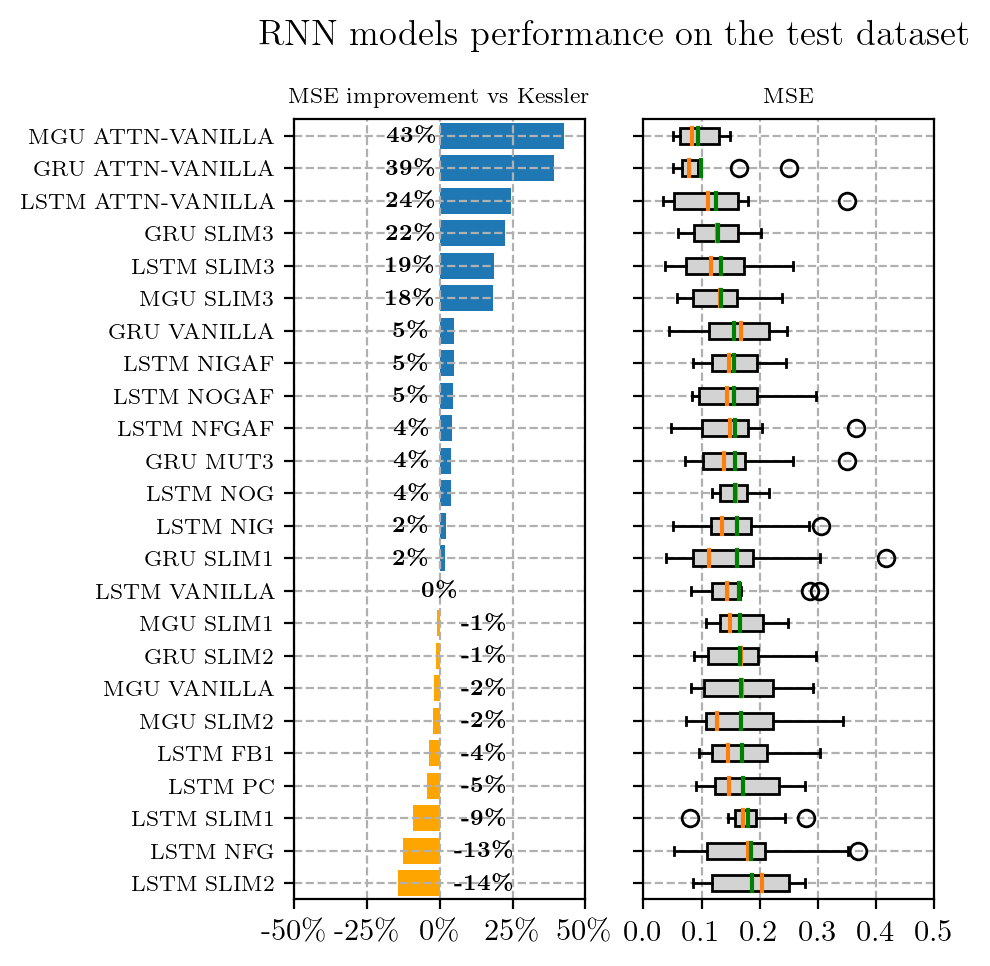

In [80]:
metric = 'mse'

df_stats.sort_values(by=f'{metric}_mean', ascending=True, inplace=True)

# Initialize dictionary to store the metric values per model and batch.
data_metric = {}
for network, test_results in data_test.items():
    data_metric[network] = test_results[metric]

# Convert dictionary to Pandas DataFrame (rows = batch, columns = networks).
dft_metric = pd.DataFrame.from_dict(data = data_metric, orient='columns')

# Reorder the columns in the original dataset to be ordered by the loss mean
dft_metric = dft_metric[df_stats.index]

# Save results in a CSV file.
dft_metric.to_csv(f'results/networks_test_{metric}.csv')

# Get mean, standard deviation, and median 
dft_metric_stats = df_stats[[c for c in df_stats.columns if c.startswith(metric)]]
dft_metric_stats.sort_values(by=f'{metric}_mean', ascending=True)


print(f'{metric.upper()} SCORES FROM TEST DATASET:')
display(dft_metric)

print(f'STATISTICS PER CONFIGURATION FOR {metric.upper()} PERFORMANCE METRIC:')
display(dft_metric_stats)

filepath = os.path.join(utils.cwd,'notebooks', 'devs', 'results',
                        f'{metric}_models_performance')

plot_results(scores = dft_metric, stats = dft_metric_stats, 
             metric = metric, filepath = filepath)